# Tydzień 1.

 Zaimplementować sieć Kohonena złożoną z neuronów w prostokątnej siatce M×N (M,N są parametrami programu), która działa dla zbioru wektorów (wszystkich o tej samej długości).

Zaimplementować następujące funkcje sąsiedztwa:

    funkcję gaussowską
    minus druga pochodną funkcji gaussowskiej.

W obu implementacjach dodać możliwość zmiany szerokości sąsiedztwa z użyciem parametru (technicznie oznacza to przemnożenie argumentu x przez stałą) i sprawdzić dla kilku wartości z przedziału [0.1,1]

Jako funkcji wygaszającą uczenie wraz z kolejnymi iteracjami użyć funkcji α(t)=e−t/λ

.

Przetestować działanie sieci na dostarczonych prostych zbiorach danych:

    danych 2d skupionych w wierzchołkach sześciokąta,
    danych 3d skupionych w wierzchołkach sześcianu.

Dane, odpowiednio hexagon i cube, mają 3/4 kolumny. Do sieci podać tylko kolumny x, y i z (w przypadku sześciokąta bez z). Ostatnia kolumna, c, zawiera identyfikator wierzchołka bryły/figury. Czy klastry w odwzorowaniu znalezionym przez sieć pokrywają się w liczbą klastrów w faktycznych danych? Czy znalezione klastry pokrywają się z identyfikatorami wierzchołków? 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import math
import matplotlib

In [48]:
class kohonen:
    def __init__(self, N,M, dataset, width, architecture):
        self.M=M
        self.N=N
        self.dataset = dataset
        self.neurons = np.random.uniform(np.min(x), np.max(x), size=(N*M,dataset.shape[1]))
        self.width = width
        self.epochs = 0
        if architecture == "hexagon":
            self.dist = self.dist_hex
        else:
            self.dist = self.dist_rec
    
    def learn(self,lambda_, method="gauss"):
        
        self.epochs += lambda_
        
        if method == "mexican":
            neighbor_function = self.mexican_hat
        else:
            neighbor_function = self.gauss
        for iteration in range(lambda_):
            p = np.random.permutation(len(self.dataset))
            x = self.dataset[p]
            for inp in x:
                minimal_pos = np.argmin([np.linalg.norm(neuron-inp) for neuron in self.neurons])
                for i,neuron in enumerate(self.neurons):
                    self.neurons[i] = neuron + neighbor_function(self.dist(self,minimal_pos,i),self.epochs + iteration - lambda_)*self.alpha_fun(self.epochs + iteration - lambda_,self.epochs)*(inp-neuron)
    
    def classify(self):
        return [np.argmin([np.linalg.norm(neuron-inp) for neuron in self.neurons]) for inp in self.dataset]
    
    def limit_neurons(self, n):
        while (len(self.neurons) > n):
            distance = np.array([np.linalg.norm(i-j) for i in self.neurons for j in self.neurons])
            distance = distance[distance!=0]
            distance = distance.reshape(len(self.neurons),len(self.neurons)-1)
            index = np.unravel_index(distance.argmin(), distance.shape)[0]
            self.neurons = np.delete(self.neurons,index,0)

    
    @staticmethod
    def dist_rec(self,x,y):
        a = x%self.N-y%self.N
        b = math.floor(x/self.N)-math.floor(y/self.N)
        
        return self.width*math.sqrt(a**2 + b**2)
    
    @staticmethod
    def dist_hex(self,x,y):
        a = self.width*((x%self.N-y%self.N))
        b = self.width*(math.floor(x/self.N)-math.floor(y/self.N))
        
        if (math.floor(x/self.N)-math.floor(y/self.N))%2==0: 
            a += 1/2
        return math.sqrt(a**2 + b**2)
    
    @staticmethod
    def alpha_fun(iteration,lambda_):
        return math.exp(-iteration/lambda_)
    
    @staticmethod
    def gauss(x,t):
        return math.exp(-(x*t)**2)
    
    @staticmethod
    def mexican_hat(x,t):
        return abs(math.exp(-(x*t)**2) * (2-4*(x*t)**2))

In [7]:
from scipy.spatial import distance
import numpy as np

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

## Hexagon

In [59]:
dataset = pd.read_csv('hexagon.csv')
labels = dataset['c']

dataset=(dataset-dataset.mean())/dataset.std()

x = np.asarray(dataset.iloc[:,[0,1]])

## Oryginalny zbiór 

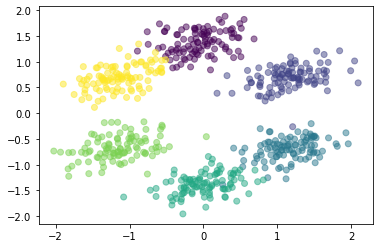

In [21]:
plt.scatter(dataset['x'], dataset['y'], c=dataset['c'], alpha=0.5)

## Funkcja porównująca własności modelu

In [92]:
def count_clustering_scores(X,model, cluster_num, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    model.learn(lambda_=500, method="gauss")
    neurony =  model.neurons
    for k in cluster_num_iter:
        model.neurons = neurony
        model.limit_neurons(k)
        labels = model.classify()
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

Używam prostej funkcji *limit_neurons* która wyrzuca jeden z neuronów które są najbliżej siebie.

Używam metryki silhouette żeby wybrać optymalną ilość klastrów.

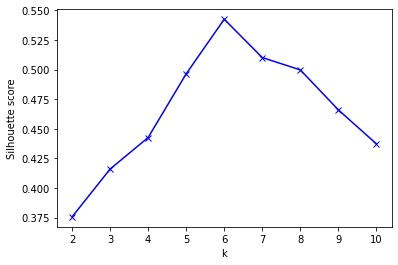

In [63]:
from sklearn.metrics import silhouette_score

model = kohonen(4,4,x,1, architecture = "rectangle")

cluster_num_seq = range(2, 11) 
silhouette_vec = count_clustering_scores(x,model, cluster_num_seq, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Widzimy, że najlepiej zbiór dzieli 6 klastrów, czyli tyle na ile oryginalnie zbiór jest podzielony.

## Testowanie *width*

In [64]:
import pandas as pd
from functools import partial


metrices = {
            'min dist between clusters': min_interclust_dist,
            'mean dist in clust': mean_inclust_dist,
            'std dev dist in clust': std_dev_of_inclust_dist,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score
           }

models = {
          'Width = 0.1': kohonen(4,4,x,0.1, architecture = "rectangle"),
          'Width = 0.2': kohonen(4,4,x,0.2, architecture = "rectangle"),
          'Width = 0.5': kohonen(4,4,x,0.5, architecture = "rectangle"),
          'Width = 1': kohonen(4,4,x,1, architecture = "rectangle")
         }

df = pd.DataFrame()
for model_key in models:
    for metric_key in metrices:
        df.loc[model_key, metric_key] = count_clustering_scores(X=x, cluster_num=6,
                                                                model=models[model_key],
                                                                score_fun=metrices[metric_key])

In [65]:
df

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
Width = 0.1,0.063362,0.496414,0.049971,0.354493,0.576969
Width = 0.2,0.073968,0.502217,0.025178,0.349254,0.568638
Width = 0.5,0.012096,0.514107,0.051618,0.349490,0.575100
Width = 1,0.058286,0.495750,0.065737,0.350398,0.570530


- Minimal distance between clusters - wszystkie szerokości poza 0.5 osiągają podobne wyniki.
- W reszcie statystyk wszystkie wypadają podobnie.

Text(0.5, 1.0, 'Width = 1')

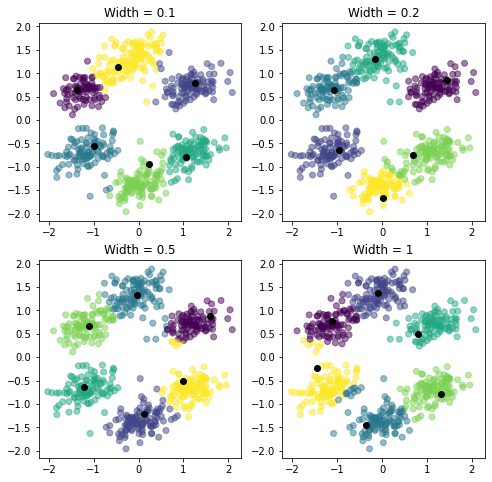

In [66]:
fig = plt.figure(figsize=(8,8))

koh = kohonen(4,4,x,0.1, architecture = "rectangle")
koh.learn(lambda_=100, method="gauss")
koh.limit_neurons(6)
c = koh.classify()

plt.subplot(2,2,1)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Width = 0.1")

koh = kohonen(4,4,x,0.2, architecture = "rectangle")
koh.learn(lambda_=100, method="gauss")
koh.limit_neurons(6)
c = koh.classify()

plt.subplot(2,2,2)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Width = 0.2")

koh = kohonen(4,4,x,0.5, architecture = "rectangle")
koh.learn(lambda_=100, method="gauss")
koh.limit_neurons(6)
c = koh.classify()

plt.subplot(2,2,3)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Width = 0.5")

koh = kohonen(4,4,x,1, architecture = "rectangle")
koh.learn(lambda_=100, method="gauss")
koh.limit_neurons(6)
c = koh.classify()

plt.subplot(2,2,4)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Width = 1")

Patrząc na wykres, najlepszy wynik osiągneliśmy dla szerokości 0.1.

## Mexican hat

In [26]:
koh = kohonen(4,4,x,0.1, architecture = "rectangle")
koh.learn(lambda_=100, method="mexican")

<ipython-input-25-85941edbb7ce>:28: RuntimeWarning: overflow encountered in add
  self.neurons[i] = neuron + neighbor_function(self.dist(self,minimal_pos,i),self.epochs + iteration - lambda_)*self.alpha_fun(self.epochs + iteration - lambda_,self.epochs)*(inp-neuron)
<ipython-input-25-85941edbb7ce>:28: RuntimeWarning: invalid value encountered in multiply
  self.neurons[i] = neuron + neighbor_function(self.dist(self,minimal_pos,i),self.epochs + iteration - lambda_)*self.alpha_fun(self.epochs + iteration - lambda_,self.epochs)*(inp-neuron)


In [27]:
koh.neurons

array([[        nan,         nan],
       [        inf,        -inf],
       [       -inf,         inf],
       [        nan,         nan],
       [        nan,         nan],
       [       -inf,         inf],
       [        inf,        -inf],
       [        nan,         nan],
       [        nan,         nan],
       [-0.70608649,  0.80589226],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan],
       [        nan,         nan]])

Oryginalna funkcja *mexican_hat* powoduje wyrzucenie wag neuronów do nieskończoności. 

Zdecydowałem się lekko zmodyfikować tę funkcję, tak aby nie osiągała  -inf, a poniżej widzimy jej testy.

Text(0.5, 1.0, 'Po 400 iteracjach')

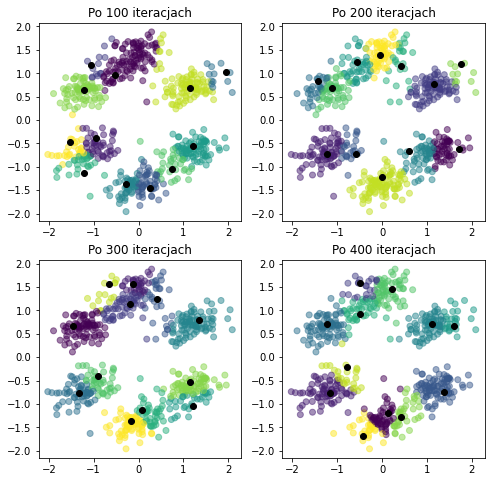

In [61]:
fig = plt.figure(figsize=(8,8))

koh = kohonen(4,3,x,0.1, architecture = "rectangle")
koh.learn(lambda_=100, method="mexican")
c = koh.classify()

plt.subplot(2,2,1)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Po 100 iteracjach")

koh.learn(lambda_=100, method="mexican")
c = koh.classify()

plt.subplot(2,2,2)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Po 200 iteracjach")

koh.learn(lambda_=100, method="mexican")
c = koh.classify()

plt.subplot(2,2,3)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Po 300 iteracjach")

koh.learn(lambda_=100, method="mexican")
c = koh.classify()

plt.subplot(2,2,4)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Po 400 iteracjach")

Widzimy, że neurony zbiegają tak, że łatwo można oddzielić je tak jakbyśmy chcieli.

In [62]:
koh.limit_neurons(6)
c = koh.classify()
print(metrics.homogeneity_score(labels, c))

0.7651921560188398


Przy połączeniu neuronów osiągamy całkiem przyzwoity wynik.

### Obserwacje po kolejnych iteracjach (bez ograniczenia liczby neuronów)

Text(0.5, 1.0, 'Po 400 iteracjach')

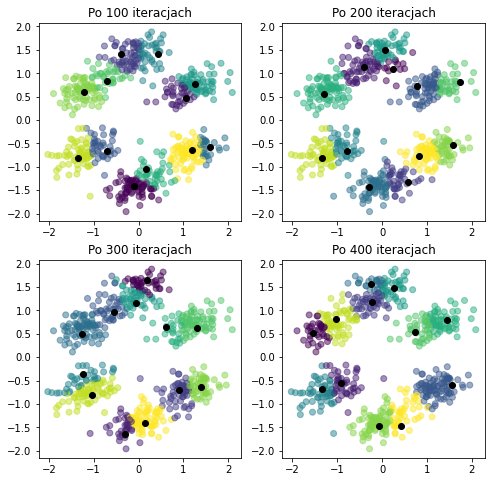

In [67]:
fig = plt.figure(figsize=(8,8))

koh = kohonen(4,3,x,0.1, architecture = "rectangle")
koh.learn(lambda_=100, method="gauss")
c = koh.classify()

plt.subplot(2,2,1)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Po 100 iteracjach")

koh.learn(lambda_=100, method="gauss")
c = koh.classify()

plt.subplot(2,2,2)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Po 200 iteracjach")

koh.learn(lambda_=100, method="gauss")
c = koh.classify()

plt.subplot(2,2,3)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Po 300 iteracjach")

koh.learn(lambda_=100, method="gauss")
c = koh.classify()

plt.subplot(2,2,4)
plt.scatter(dataset['x'], dataset['y'], c=c, alpha=0.5)
plt.scatter(koh.neurons[:,0],koh.neurons[:,1], color = "black")
plt.title("Po 400 iteracjach")

Widzimy, że neurony zbiegają w swoją stronę, więc ma sens późniejsze łączenie ich. 

In [68]:
koh.limit_neurons(6)
c = koh.classify()
print(metrics.homogeneity_score(labels, c))

0.887591868669153


Funkcja Gaussa wypada bardzo dobrze, lepiej od kapelusza.

## Cube 

Dla zbioru *Cube* wykonam mniej testów, ponieważ trudniej jest oglądać wyniki na wykresach 3d.

Obserwacje nt. poniższych wykresów opierają się na scatterach 3d które można obracać. Niestety musiałem zmienić je na statyczne, ponieważ te oryginalne nie wyświetlają się bez skompilowania notebooka.

In [69]:
dataset = pd.read_csv('cube.csv')
x = np.asarray(dataset.iloc[:,[0,1,2]])

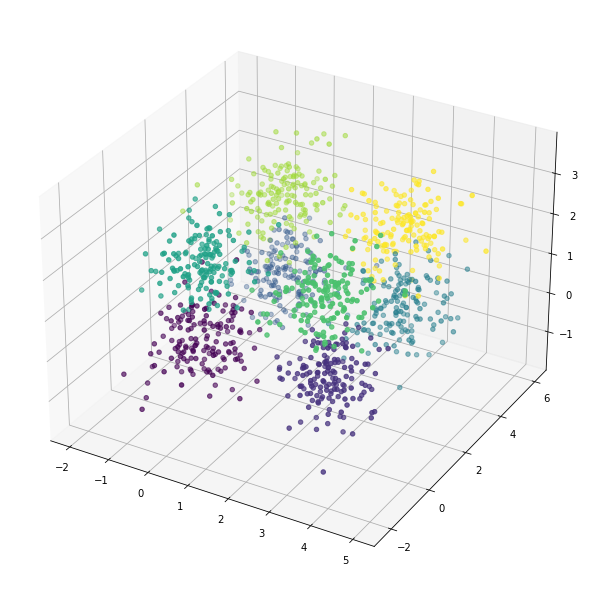

In [100]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=dataset['c'])

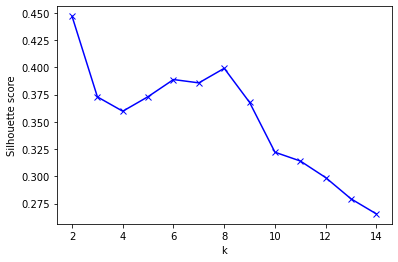

In [93]:
from sklearn.metrics import silhouette_score

model = kohonen(4,4,x,1, architecture = "rectangle")

cluster_num_seq = range(2, 15) 
silhouette_vec = count_clustering_scores(x,model, cluster_num_seq, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

Niestety tym razem metryka *Silhouette* nie potwierdza oryginalnego podziału, jednak jest bardzo blisko najwyższej wartości. Podział na 2 klastry zazwyczaj można odrzucić, ponieważ jest zbyt ogólny.

## Funkcja Gaussa

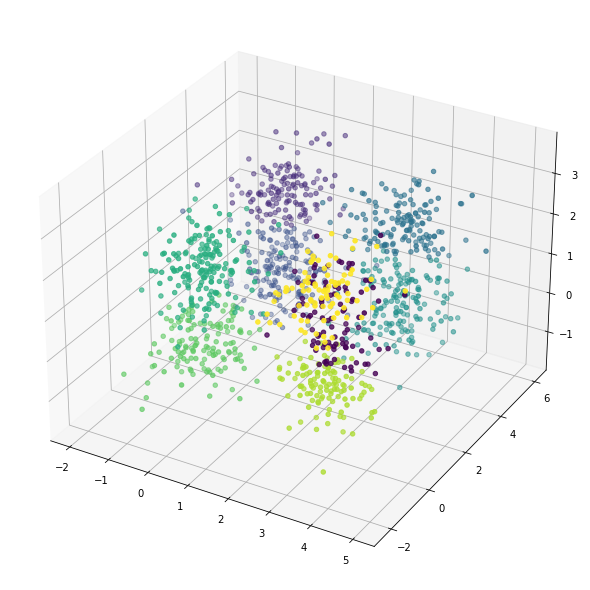

In [101]:
koh = kohonen(3,3,x,1, 'rectangle')
koh.neurons
koh.learn(lambda_=100, method="gauss")
c = koh.classify()

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=c)

## Mexican hat

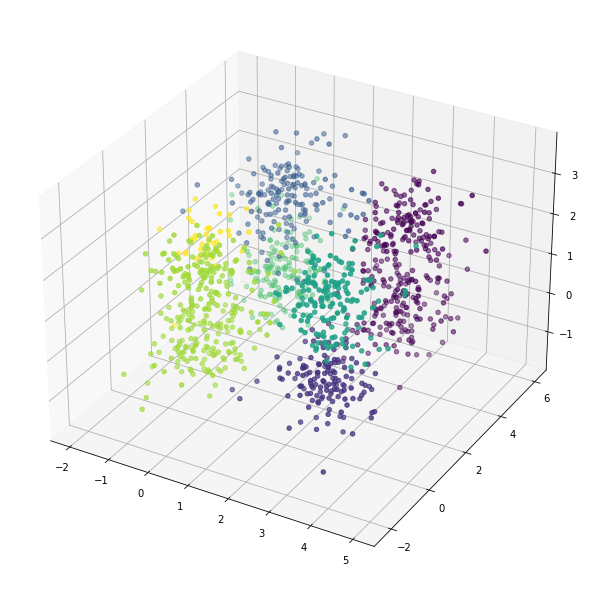

In [102]:
koh = kohonen(3,3,x,1, 'rectangle')
koh.neurons
koh.learn(lambda_=100, method="mexican")
c = koh.classify()

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=c)

"Na oko" funkcja Gaussa znowu działa dużo lepiej. Widzimy, że wszystkie klastry się zgadzają, poza jednym który został podzielony na dwa mniejsze (wynika to z architektury). Mexican hat poradził sobie dużo gorzej i widzimy, że granice między klastrami się zacierają. 

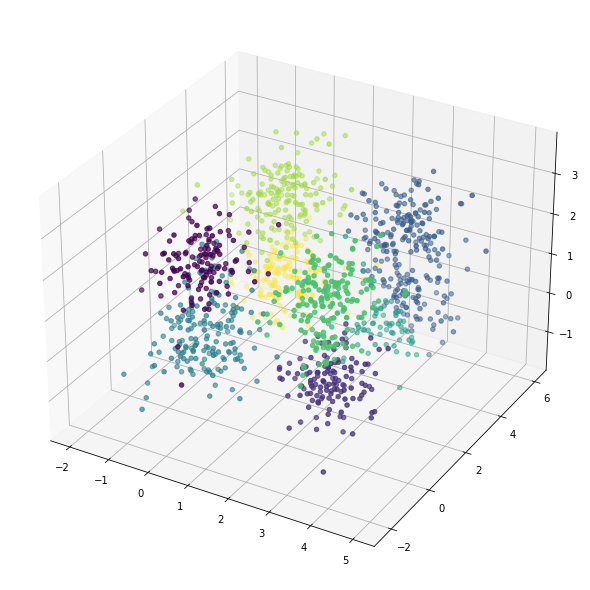

In [103]:
koh = kohonen(4,4,x,1, 'rectangle')
koh.neurons
koh.learn(lambda_=500, method="gauss")
koh.limit_neurons(8)
c = koh.classify()

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax.scatter(dataset['x'], dataset['y'], dataset['z'], c=c)

Widzimy, że przy większej siatce, a później ograniczeniu liczby neuronów klasteryzacja wygląda praktycznie identycznie co oryginalna. 

In [83]:
print(metrics.homogeneity_score(dataset['c'], c))

0.8763504005156241


Wynik potwierdza dobrą klasteryzację.